## Problem Statement:
To See we you can find any other trends in heart data to predict certain cardiovascular events or find any clear indications of heart health.

* Identify the attributes which explains the prediction

### Dataset reference:
https://www.kaggle.com/ronitf/heart-disease-uci

## Import Packages

In [625]:
# import Required Packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas_profiling
import pylab
from sklearn.model_selection import train_test_split
from scipy import stats
import sklearn.preprocessing as preproc
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.metrics import cohen_kappa_score


from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_curve, auc

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)


## Define Data Class

In [630]:
#read dataset
class Data:
    def __init__(self, path, file,categorical_cols, numerical_cols, boolean_cols,target_col,for_prediction):
        self.path = path
        self.file = file

        self.categorical_cols = list(categorical_cols)
        self.numerical_cols = list(numerical_cols)
        self.boolean_cols = list(boolean_cols)
        self.target_col = list(target_col)
        self.col_list = categorical_cols+numerical_cols+boolean_cols
        self.for_prediction = for_prediction
        self.for_prediction = for_prediction
        
        self.DS = self._read_csv_to_DF()
        #self._exportEDA(self.DS)
        self._chk_duplicate_clean()
               

    def _read_csv_to_DF(self):  #read CSV to dataframe
        DS = pd.read_csv(self.path+'/'+self.file)
        print(str(DS.shape[0]) + ' observations with '+str(DS.shape[1])+' Features loaded \n')
        return DS
    
    def _exportEDA(self): #export feature analysis profiling 
        profile = self.DS.profile_report(title='Pandas Profiling Report - EDA_output.html \n')
        profile.to_file(output_file="EDA_output.html")
        pass
    
    def _chk_duplicate_clean(self): #remove duplicate records
        dup = self.DS[self.DS.duplicated()].copy()
        print('removed duplicate observations- '+ str(dup.shape[0])+'\n')
        self.DS.drop_duplicates(keep='first',inplace=True) 
        pass
    
    def _splitdata(self): #split train/test dataset (for_prediction= true, data for prediction been passed)
        copy_DS = self.DS.copy()
        X= self.DS.drop('target',axis=1)
        y= self.DS['target']      
        
        if self.for_prediction:
            return copy_DS,X,y
        else:
           
            train_set,test_set,train_target,test_target = train_test_split(X,y,test_size=.3,random_state=42)
            return train_set,test_set,train_target,test_target

## Define Transformation Class

In [631]:
class Transformation:
    def __init__(self,dataset,col_logT,col_boxCoxT,categorical_cols,scale_cols,transLamda, for_prediction):
        self.dataset = dataset
        self.for_prediction = for_prediction
        self.col_logT = list(col_logT)
        self.col_boxCoxT = list(col_boxCoxT)
        self.categorical_cols = list(categorical_cols) 
        self.scale_cols =list(scale_cols)
        self.ColLambda = transLamda
        self.__applyFeatureTransformation()
           
        
    def _storeTransLamda(self, colname,lamda): # store Lambda from transformation to fit Test/Prediction data 
        self.ColLambda.update({colname:lamda})
        pass
        
    def _apply_BoxCoxTrans(self, colname): # BoxCox Transformation, returns lamda for test set
        newcol = colname+'BCox'
        #print(self.ColLambda)
        if self.for_prediction:
            fitted_lambda = self.ColLambda.get(colname)
            trn_data = stats.boxcox(self.dataset[colname], fitted_lambda)
            self.dataset[newcol] = trn_data
            self.dataset.drop(columns = colname,inplace =True)
            print(colname +' feature transformed: '+newcol)
        else:
            trn_data,fitted_lambda = stats.boxcox(self.dataset[colname])
            self.dataset[newcol] = trn_data
            self.dataset.drop(columns = colname,inplace =True)
            print(colname +' feature transformed: '+newcol)
            self._storeTransLamda(colname,fitted_lambda)
        
    def _applyStandardization(self,colname): # Feature Standardization 
        newcol=colname+'-Tstd'
        self.dataset[newcol] = preproc.StandardScaler().fit_transform(self.dataset[[colname]])
        self.dataset.drop(columns = colname,inplace =True)
        print(colname +' feature transformed: '+newcol)
    
    def _dummyEncode_category(self, colname): # Dummy Encode Categorical features
        newcol = colname+'-'
        DS_dummytype = pd.get_dummies(self.dataset[colname],prefix=newcol)
        self.dataset= pd.concat((self.dataset,DS_dummytype),axis=1)
        self.dataset = self.dataset.drop(columns=colname,axis=1)
    
    def _MinMax_scaling(self,colname):
        newcol=colname+'-MM'
        self.dataset[newcol] = preproc.minmax_scale(self.dataset[[colname]])
        print(colname +' feature scaled: '+newcol)
        self.dataset = self.dataset.drop(columns=colname,axis=1)
        
        
    def __applyFeatureTransformation(self):
        if self.col_boxCoxT:
            #print('BoxCox Transformation')
            for colname in col_boxCoxT:
                self._apply_BoxCoxTrans(colname)

        if self.col_logT:
            print('Log Transformation')
            for colname in col_logT:
                self._applyStandardization(colname)

        if self._dummyEncode_category:
            print('Dummy Encoded'+ str(categorical_cols) + ' \n')
            for colname in categorical_cols:
                self._dummyEncode_category(colname)
        
        if self.scale_cols:#Min-Max Scaling
            print('Feature Scaling '+ str(scale_cols) + ' \n')
            for colname in scale_cols:
                self._MinMax_scaling(colname)
            
        

#apply_standardization(DS,'thalachBCox',keepexistingcol = False)  
     
    def _returnTransformation(self):
        if self.for_prediction:
            return self.dataset, list(self.dataset)
        else:
            return self.dataset, self.ColLambda, list(self.dataset)
        

## Define Model Container

In [632]:
class ModelContainer:
    def __init__(self, models=[]):
        '''initializes model list and dicts'''
        self.models = models
        self.best_model = None
        self.predictions = None
        self.model_accuracy = {}
    
    def add_model(self, model):
        self.models.append(model)
            
    def select_best_model(self):
        '''select model with lowest mse'''
        self.best_model = max(self.model_accuracy, key=self.model_accuracy.get)
        
    def best_model_fit(self, features, targets):
        '''fits best model'''
        self.best_model.fit(features, targets)
    
    def best_model_predict(self, features):
        '''scores features using best model'''
        self.predictions = self.best_model.predict(features)
        return self.predictions
       
    def train_models(self,data):
        feature_df = TrainDS
        target_df = train_target
        for model in self.models:
            model.fit(feature_df, target_df)
            pred = model.predict(TestDS)
            score = accuracy_score(pred, test_target)
            ck_score = cohen_kappa_score(pred, test_target)
            cross_score = cross_val_score(model, feature_df, target_df, scoring='accuracy', cv = 10)
            print("Model : %s" % model)
            print("Accuracy : %s" % score)
            print("Cohem_Kappa : %s" % ck_score)
            print("Cross_Val_Score : %s" % cross_score.mean())
            print('Confusion Matrix')
            cm = confusion_matrix(test_target, pred)
            print(cm) 
            sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
            print('Sensitivity : ', sensitivity )
            specificity = cm[1,1]/(cm[1,1]+cm[0,1])
            print('Specificity : ', specificity)
            print("---------------------------------------------------------------------")
            self.model_accuracy[model] = score
            
 
    def print_summary(self):
        '''prints summary of models, best model'''
        print('\nModel Summaries:\n')
        print('\nBest Model:\n', models.best_model)
        print('\n Test Accuracy of best model: \n', models.model_accuracy[models.best_model])
        
        Y_predicted_Prob = models.best_model.predict_proba(TestDS)[:, 1]
        fpr, tpr, thresholds = roc_curve(test_target, Y_predicted_Prob)
        print('AUC - ' + str(auc(fpr, tpr)))
        fig, ax = plt.subplots()
        ax.plot(fpr, tpr)
        ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c=".3")
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.rcParams['font.size'] = 12
        plt.title('ROC curve for diabetes classifier')
        plt.xlabel('False Positive Rate (1 - Specificity)')
        plt.ylabel('True Positive Rate (Sensitivity)')
        plt.grid(True)
         

## Workflow

### Data Variables - Declarations

In [633]:
# data load 
path = "D:/Datasets/HeartDiseaseUCI/heart-disease-uci"
file ='heart.csv'

numeric_cols = ['age','chol','oldpeak','trestbps','thalach']
categorical_cols = ['ca','cp','exang','slope','thal','restecg']
boolean_cols = ['exang','fbs','sex']
target_col = ['target']
scale_cols = ['thalachBCox','ageBCox']

data = Data(path,file,categorical_cols, numeric_cols, boolean_cols,target_col,for_prediction=0)
train_set,test_set,train_target,test_target = data._splitdata()

# Normalize the train features - apply tansformations
col_logT= []
transLamda = {}
col_boxCoxT= ['chol','thalach','age','trestbps']


303 observations with 14 Features loaded 

removed duplicate observations- 1



### Feature Engineer Train Set

In [634]:
trainobj = Transformation(train_set,col_logT,col_boxCoxT,categorical_cols,scale_cols,transLamda ,for_prediction = False)
TrainDS, transLamda, totalColList =  trainobj._returnTransformation()

chol feature transformed: cholBCox
thalach feature transformed: thalachBCox
age feature transformed: ageBCox
trestbps feature transformed: trestbpsBCox
Dummy Encoded['ca', 'cp', 'exang', 'slope', 'thal', 'restecg'] 

Feature Scaling ['thalachBCox', 'ageBCox'] 

thalachBCox feature scaled: thalachBCox-MM
ageBCox feature scaled: ageBCox-MM


### Transform Test Set

In [635]:
testobj = Transformation(test_set,col_logT,col_boxCoxT,categorical_cols,scale_cols,transLamda,for_prediction = True)
TestDS,testcols =  testobj._returnTransformation()
for col in totalColList:
    if col in testcols:
        pass
    else:
        TestDS[col]=0

chol feature transformed: cholBCox
thalach feature transformed: thalachBCox
age feature transformed: ageBCox
trestbps feature transformed: trestbpsBCox
Dummy Encoded['ca', 'cp', 'exang', 'slope', 'thal', 'restecg'] 

Feature Scaling ['thalachBCox', 'ageBCox'] 

thalachBCox feature scaled: thalachBCox-MM
ageBCox feature scaled: ageBCox-MM


### Add Models

In [643]:
num_procs = 4

models = ModelContainer()
#create models -- hyperparameter tuning already done by hand for each model
models.add_model(RandomForestClassifier( max_depth=5, min_samples_split=2
                                      , min_samples_leaf=1, min_weight_fraction_leaf=0.0,
                                      max_features='auto', max_leaf_nodes=2, min_impurity_decrease=0.0,
                                      min_impurity_split=None, bootstrap=True, oob_score=True
                                      , n_jobs=None, random_state=42, verbose=0, warm_start=False, class_weight=None))
models.add_model(GaussianNB())
models.add_model(LogisticRegression(random_state=0))
#models.add_model(SVC(random_state = 1,probability=True))

models.add_model(SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))


### Model Train

Model : RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=2,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=True, random_state=42, verbose=0, warm_start=False)
Accuracy : 0.8351648351648352
Cohem_Kappa : 0.6666666666666667
Cross_Val_Score : 0.7907575757575758
Confusion Matrix
[[33  9]
 [ 6 43]]
Sensitivity :  0.8461538461538461
Specificity :  0.8269230769230769
---------------------------------------------------------------------
Model : GaussianNB(priors=None, var_smoothing=1e-09)
Accuracy : 0.7032967032967034
Cohem_Kappa : 0.42174629324546953
Cross_Val_Score : 0.7814069264069263
Confusion Matrix
[[38  4]
 [23 26]]
Sensitivity :  0.6229508196721312
Specificity :  0.8666666666666667
---------------------------------------------------------

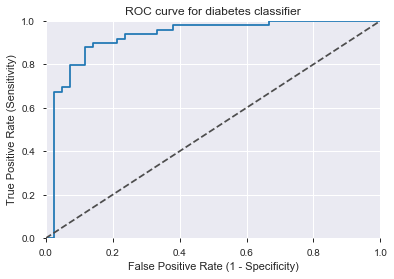

In [644]:
#models.cross_validate(TrainDS, k=2, num_procs=num_procs)
#models.select_best_model()
#models.best_model_fit(TrainDS, train_target)
#models.best_model_predict(TestDS)
models.train_models(TrainDS)
models.select_best_model()
models.print_summary()

In [642]:
models.best_model_predict(TestDS)

array([0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0,
       1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1,
       1, 0, 1], dtype=int64)

In [608]:
#NEw dataset prediction

In [645]:
# data load 
path = "D:/Datasets/HeartDiseaseUCI/heart-disease-uci"
file ='heart1.csv'

numeric_cols = ['age','chol','oldpeak','trestbps','thalach']
categorical_cols = ['ca','cp','exang','slope','thal','restecg']
boolean_cols = ['exang','fbs','sex']
target_col = ['target']
scale_cols = ['thalachBCox','ageBCox']
data = Data(path,file,categorical_cols, numeric_cols, boolean_cols,target_col,for_prediction=True)
DS,test_set,test_target = data._splitdata()

testobj = Transformation(test_set,col_logT,col_boxCoxT,categorical_cols,scale_cols,transLamda,for_prediction = True)
TestDS,testcols =  testobj._returnTransformation()
for col in totalColList:
    if col in testcols:
        pass
    else:
        TestDS[col]=0

predicted_target = models.best_model_predict(TestDS)
DS['prediction'] = predicted_target 
DS

3 observations with 14 Features loaded 

removed duplicate observations- 0

chol feature transformed: cholBCox
thalach feature transformed: thalachBCox
age feature transformed: ageBCox
trestbps feature transformed: trestbpsBCox
Dummy Encoded['ca', 'cp', 'exang', 'slope', 'thal', 'restecg'] 

Feature Scaling ['thalachBCox', 'ageBCox'] 

thalachBCox feature scaled: thalachBCox-MM
ageBCox feature scaled: ageBCox-MM


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target,prediction
0,69,0,3,140,239,0,1,151,0,1.8,2,2,2,1,0
1,71,0,1,160,302,0,1,162,0,0.4,2,2,2,1,0
2,59,1,2,150,212,1,1,157,0,1.6,2,0,2,1,1


## Classisfication Visualization

C:\Users\mvaithianathan\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\mvaithianathan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


<class 'list'>


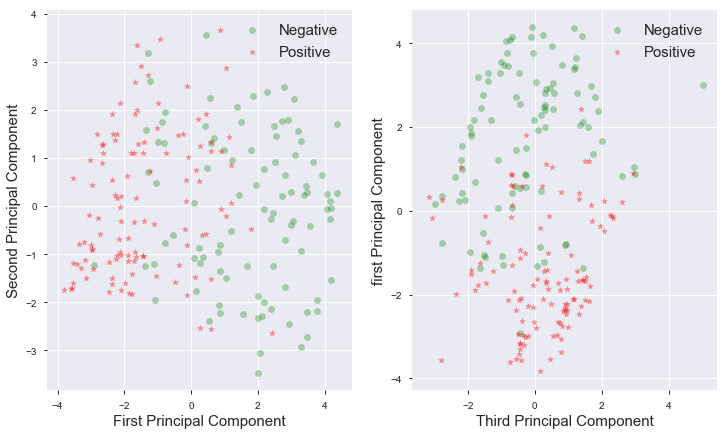

In [582]:
scaler1 = StandardScaler()
scaler1.fit(transformedset)
feature_scaled = scaler1.transform(transformedset)

#now apply PCA
from sklearn.decomposition import PCA
pca1 =  PCA(n_components =4)
pca1.fit(feature_scaled)
feature_scaled_pca =  pca1.transform(feature_scaled)

target_list = train_target.tolist()
print (type(target_list))
feature_scaled_pca_X0 = feature_scaled_pca[:, 0]
feature_scaled_pca_X1 = feature_scaled_pca[:, 1]
feature_scaled_pca_X2 = feature_scaled_pca[:, 2]
#feature_scaled_pca_X3 = feature_scaled_pca[:, 3]

labels = target_list
colordict = {0:'green', 1:'red'}
piclabel = {0:'Negative', 1:'Positive'}
markers = {0:'o', 1:'*'}
alphas = {0:0.3, 1:0.4}

fig = plt.figure(figsize=(12, 7))
plt.subplot(1,2,1)
for l in np.unique(labels):
    ix = np.where(labels==l)
    plt.scatter(feature_scaled_pca_X0[ix], feature_scaled_pca_X1[ix], c=colordict[l], 
               label=piclabel[l], s=40, marker=markers[l], alpha=alphas[l])
plt.xlabel("First Principal Component", fontsize=15)
plt.ylabel("Second Principal Component", fontsize=15)

plt.legend(fontsize=15)

plt.subplot(1,2,2)
for l1 in np.unique(labels):
    ix1 = np.where(labels==l1)
    plt.scatter(feature_scaled_pca_X2[ix1], feature_scaled_pca_X0[ix1], c=colordict[l1], 
               label=piclabel[l1], s=40, marker=markers[l1], alpha=alphas[l1])
plt.xlabel("Third Principal Component", fontsize=15)
plt.ylabel("first Principal Component", fontsize=15)

plt.legend(fontsize=15)

plt.savefig('heartDisease_PCAs.png', dpi=200)
plt.show()

In [611]:

from sklearn.model_selection import GridSearchCV 
  
# defining parameter range 
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf']}  
  
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3) 
  
# fitting the model for grid search 
grid.fit(TrainDS, train_target) 

Fitting 3 folds for each of 25 candidates, totalling 75 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV]  C=0.1, gamma=1, kernel=rbf, score=0.5492957746478874, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV]  C=0.1, gamma=1, kernel=rbf, score=0.5428571428571428, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV]  C=0.1, gamma=1, kernel=rbf, score=0.5428571428571428, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV]  C=0.1, gamma=0.1, kernel=rbf, score=0.9154929577464789, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV]  C=0.1, gamma=0.1, kernel=rbf, score=0.7571428571428571, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] .......... C=0.1, gamma=0.1, kernel=rbf, score=0.8, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=rbf .................................

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV]  C=1, gamma=0.0001, kernel=rbf, score=0.5428571428571428, total=   0.0s
[CV] C=1, gamma=0.0001, kernel=rbf ...................................
[CV]  C=1, gamma=0.0001, kernel=rbf, score=0.5428571428571428, total=   0.0s
[CV] C=10, gamma=1, kernel=rbf .......................................
[CV]  C=10, gamma=1, kernel=rbf, score=0.7746478873239436, total=   0.0s
[CV] C=10, gamma=1, kernel=rbf .......................................
[CV]  C=10, gamma=1, kernel=rbf, score=0.6857142857142857, total=   0.0s
[CV] C=10, gamma=1, kernel=rbf .......................................
[CV]  C=10, gamma=1, kernel=rbf, score=0.7285714285714285, total=   0.0s
[CV] C=10, gamma=0.1, kernel=rbf .....................................
[CV]  C=10, gamma=0.1, kernel=rbf, score=0.7746478873239436, total=   0.0s
[CV] C=10, gamma=0.1, kernel=rbf .....................................
[CV]  C=10, gamma=0.1, kernel=rbf, score=0.7428571428571429, total=   0.0s
[CV] C=10, gamma=0.1, kernel=rbf ..................

[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:    0.4s finished
C:\Users\mvaithianathan\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.1, 1, 10, 100, 1000], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 'kernel': ['rbf']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)